# Data : 
DrDoS can belong to one of the following class : 
 * DrDoS_DNS
 * DrDoS_LDAP
 * DrDoS_MSSQL
 * DrDoS_NTP
 * DrDoS_NetBIOS
 * DrDoS_SNMP
 * DrDoS_SSDP
 * DrDoS_UDP
 * Syn
 * TFTP
 * UDPLag


# Image-based DrDoS Classification using CNN architectures




# CNN model

Copying files: 9195 files [00:07, 1249.72 files/s]


Found 5887 images belonging to 11 classes.
Found 1466 images belonging to 11 classes.
Found 1842 images belonging to 11 classes.
Epoch 1/35
184/184 [==============================] - 36s 191ms/step - loss: 5.9929 - accuracy: 0.4231 - val_loss: 15.8291 - val_accuracy: 0.1555 - lr: 0.0010
Epoch 2/35
184/184 [==============================] - 33s 180ms/step - loss: 3.8085 - accuracy: 0.5505 - val_loss: 4.1153 - val_accuracy: 0.4427 - lr: 0.0010
Epoch 3/35
184/184 [==============================] - 33s 178ms/step - loss: 2.6660 - accuracy: 0.6480 - val_loss: 2.1368 - val_accuracy: 0.7749 - lr: 0.0010
Epoch 4/35
184/184 [==============================] - 33s 181ms/step - loss: 2.0003 - accuracy: 0.7493 - val_loss: 2.0135 - val_accuracy: 0.6903 - lr: 0.0010
Epoch 5/35
184/184 [==============================] - 33s 178ms/step - loss: 1.6444 - accuracy: 0.7951 - val_loss: 1.5953 - val_accuracy: 0.8063 - lr: 0.0010
Epoch 6/35
184/184 [==============================] - 33s 181ms/step - loss: 1.3

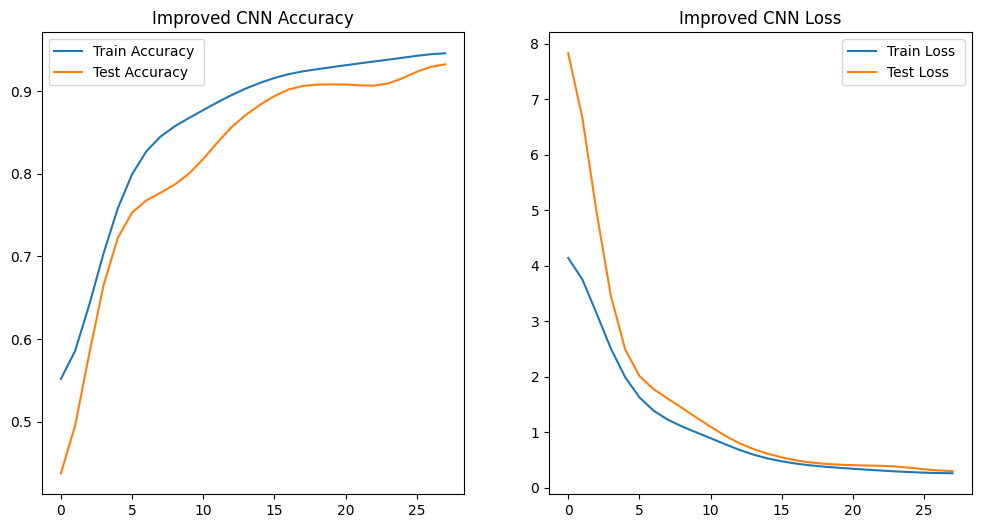

58/58 [==============================] - 3s 42ms/step

Improved CNN Performance:
Accuracy: 0.9180
Precision: 0.9306
Recall: 0.9180
AUC: 0.9958
Test Time: 2.67 seconds
CPU Usage During Testing: 39.20%
Memory Usage During Testing: 202.16 MB


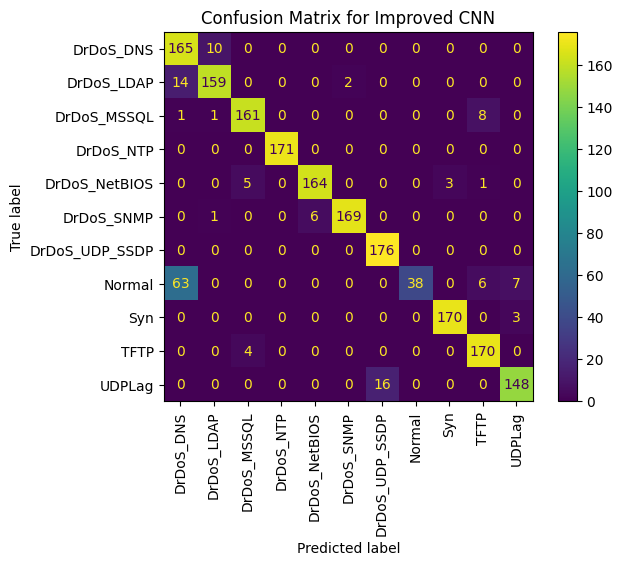

In [35]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenetv2_preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import time
import psutil
import shutil

# Function for CNN model with Batch Normalization and Dropout
def improved_cnn(input_shape, n_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
    x = Dropout(0.5)(x)  # Increased dropout rate
    outputs = tf.keras.layers.Dense(n_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Dataset sampling
def sample_dataset(src_dir, dest_dir, sample_size=500):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    for class_dir in os.listdir(src_dir):
        full_class_dir = os.path.join(src_dir, class_dir)
        if os.path.isdir(full_class_dir):
            sampled_class_dir = os.path.join(dest_dir, class_dir)
            if not os.path.exists(sampled_class_dir):
                os.makedirs(sampled_class_dir)
            all_files = os.listdir(full_class_dir)
            sampled_files = np.random.choice(all_files, min(sample_size, len(all_files)), replace=False)
            for file_name in sampled_files:
                shutil.copy(os.path.join(full_class_dir, file_name), sampled_class_dir)

# Dataset splitting
def split_dataset(train_data_dir: str, dest_path: str, train_ratio: float, test_ratio: float):
    import splitfolders
    splitfolders.ratio(input=train_data_dir, output=dest_path, seed=1337, ratio=(train_ratio, 0, test_ratio), group_prefix=None, move=False)

# Image Processor Class
class ImageProcessor:
    def __init__(self, preprocess_fx, train_dir: str, test_dir: str, size, colormode: str, validation_split: float = 0.2):
        self.preprocess_fx = preprocess_fx
        self.train_gen = None
        self.test_gen = None
        self.colormode = colormode
        self.TRAIN_DIR = train_dir
        self.TEST_DIR = test_dir
        self.size = size
        self.validation_split = validation_split

    def create_generators(self):
        self.train_gen = ImageDataGenerator(
            preprocessing_function=self.preprocess_fx,
            validation_split=self.validation_split,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True
        )
        self.test_gen = ImageDataGenerator(
            preprocessing_function=self.preprocess_fx
        )

    def get_images(self):
        train_images = self.train_gen.flow_from_directory(
            directory=self.TRAIN_DIR,
            target_size=self.size,
            color_mode=self.colormode,
            class_mode='categorical',
            batch_size=32,
            shuffle=True,
            subset='training'
        )
        val_images = self.train_gen.flow_from_directory(
            directory=self.TRAIN_DIR,
            target_size=self.size,
            color_mode=self.colormode,
            class_mode='categorical',
            batch_size=32,
            shuffle=True,
            subset='validation'
        )
        test_images = self.test_gen.flow_from_directory(
            directory=self.TEST_DIR,
            target_size=self.size,
            color_mode=self.colormode,
            class_mode='categorical',
            batch_size=32,
            shuffle=False
        )
        return train_images, val_images, test_images

# Measure Performance with Metrics
def measure_performance_with_metrics(model, test, title):
    process = psutil.Process()
    cpu_usage_testing_start = process.cpu_percent(interval=None)
    memory_usage_start = process.memory_info().rss / 1024 ** 2
    start_time = time.time()

    predictions = model.predict(test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test.labels
    true_classes_one_hot = tf.keras.utils.to_categorical(true_classes, num_classes=len(test.class_indices))

    end_time = time.time()
    cpu_usage_testing_end = process.cpu_percent(interval=None)
    memory_usage_end = process.memory_info().rss / 1024 ** 2

    # Calculate metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    auc = roc_auc_score(true_classes_one_hot, predictions, multi_class='ovr')
    test_time = end_time - start_time

    avg_cpu_testing = (cpu_usage_testing_start + cpu_usage_testing_end) / 2
    avg_memory_testing = (memory_usage_start + memory_usage_end) / 2

    # Print metrics
    print(f"\n{title} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"Test Time: {test_time:.2f} seconds")
    print(f"CPU Usage During Testing: {avg_cpu_testing:.2f}%")
    print(f"Memory Usage During Testing: {avg_memory_testing:.2f} MB")

    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test.class_indices.keys())
    disp.plot(cmap="viridis", xticks_rotation='vertical')
    plt.title(f"Confusion Matrix for {title}")
    plt.show()

# Plot Accuracy and Loss with Smoothing
def plot_accuracy_loss_smooth(history, title, sigma=2):
    train_acc_smooth = gaussian_filter1d(history.history['accuracy'], sigma=sigma)
    val_acc_smooth = gaussian_filter1d(history.history['val_accuracy'], sigma=sigma)
    train_loss_smooth = gaussian_filter1d(history.history['loss'], sigma=sigma)
    val_loss_smooth = gaussian_filter1d(history.history['val_loss'], sigma=sigma)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].plot(train_acc_smooth, label='Train Accuracy ')
    axs[0].plot(val_acc_smooth, label='Test Accuracy ')
    axs[0].set_title(f'{title} Accuracy')
    axs[0].legend()

    axs[1].plot(train_loss_smooth, label='Train Loss ')
    axs[1].plot(val_loss_smooth, label='Test Loss ')
    axs[1].set_title(f'{title} Loss')
    axs[1].legend()

    plt.show()

# Main Script
DDoS_dir = r'C:\Users\amerl\Desktop'
sampled_train_dir = 'Train01'
sample_dataset(os.path.join(DDoS_dir, "Train"), sampled_train_dir, sample_size=500)
split_dataset(sampled_train_dir, "blended/", 0.8, 0.2)

# Initialize Image Processor
img_processor = ImageProcessor(mobilenetv2_preprocess_input, 
                                os.path.join("blended", "train"), 
                                os.path.join("blended", "test"), 
                                (75, 75), "rgb")
img_processor.create_generators()
train, val, test = img_processor.get_images()

# Build Improved Model
cnn_model = improved_cnn((75, 75, 3), len(train.class_indices))
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

# Measure CPU and Memory Usage for Training
process = psutil.Process()
cpu_usage_training_start = process.cpu_percent(interval=None)
memory_usage_training_start = process.memory_info().rss / 1024 ** 2
start_train = time.time()

cnn_history = cnn_model.fit(
    train,
    validation_data=val,
    epochs=35,
    callbacks=[early_stopping, reduce_lr]
)

end_train = time.time()
cpu_usage_training_end = process.cpu_percent(interval=None)
memory_usage_training_end = process.memory_info().rss / 1024 ** 2

avg_cpu_training = (cpu_usage_training_start + cpu_usage_training_end) / 2
avg_memory_training = (memory_usage_training_start + memory_usage_training_end) / 2

print(f"Training Time: {end_train - start_train:.2f} seconds")
print(f"Average CPU Usage During Training: {avg_cpu_training:.2f}%")
print(f"Average Memory Usage During Training: {avg_memory_training:.2f} MB")

# Plot Accuracy and Loss
plot_accuracy_loss_smooth(cnn_history, "Improved CNN")

# Measure Performance with Metrics
measure_performance_with_metrics(cnn_model, test, "Improved CNN")


# EfficientNetB0 model 

Found 7942 images belonging to 11 classes.
Found 1979 images belonging to 11 classes.
Found 5792 images belonging to 11 classes.
Epoch 1/10
249/249 [==============================] - 276s 1s/step - loss: 0.9382 - accuracy: 0.7010 - val_loss: 0.4206 - val_accuracy: 0.9025 - lr: 0.0010
Epoch 2/10
249/249 [==============================] - 268s 1s/step - loss: 0.4534 - accuracy: 0.8675 - val_loss: 0.3372 - val_accuracy: 0.9156 - lr: 0.0010
Epoch 3/10
249/249 [==============================] - 266s 1s/step - loss: 0.3675 - accuracy: 0.8978 - val_loss: 0.2989 - val_accuracy: 0.9308 - lr: 0.0010
Epoch 4/10
249/249 [==============================] - 289s 1s/step - loss: 0.3203 - accuracy: 0.9121 - val_loss: 0.2695 - val_accuracy: 0.9257 - lr: 0.0010
Epoch 5/10
249/249 [==============================] - 295s 1s/step - loss: 0.2892 - accuracy: 0.9209 - val_loss: 0.2642 - val_accuracy: 0.9272 - lr: 0.0010
Epoch 6/10
249/249 [==============================] - 291s 1s/step - loss: 0.2745 - accurac

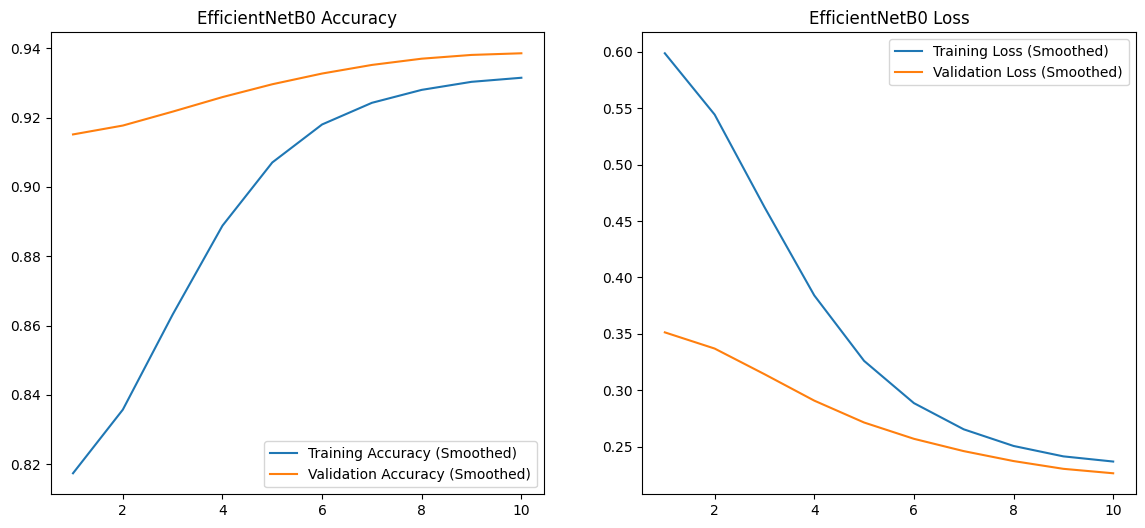

181/181 [==============================] - 172s 940ms/step

EfficientNetB0 Performance Metrics:
Accuracy: 0.95
Precision: 0.96
Recall: 0.95
AUC: 1.00


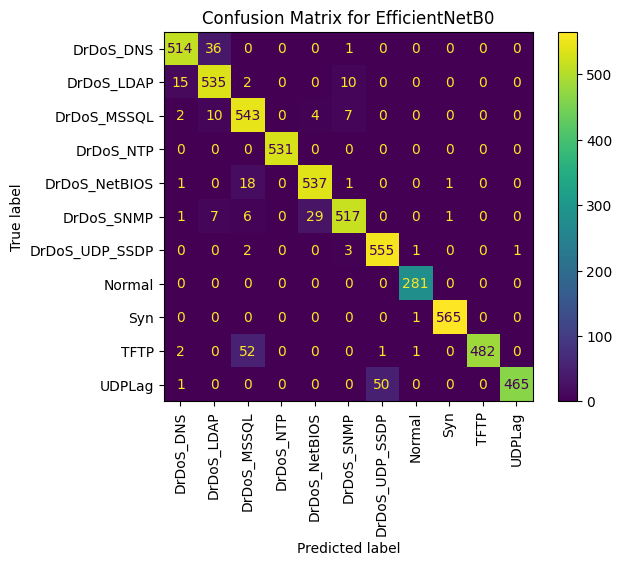

In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time
from scipy.ndimage import gaussian_filter1d
import psutil

# Helper Function to Build and Train the Model
def build_and_train_efficientnet(preprocess_fx, dataset_dir, output_dir, input_shape, base_model, n_classes, augment_data=True, epochs=10):
    # Data Augmentation
    if augment_data:
        data_gen = ImageDataGenerator(
            preprocessing_function=preprocess_fx,
            validation_split=0.2,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True
        )
    else:
        data_gen = ImageDataGenerator(
            preprocessing_function=preprocess_fx,
            validation_split=0.2
        )
    
    # Data Generators
    train_gen = data_gen.flow_from_directory(
        os.path.join(dataset_dir, "train"),
        target_size=input_shape[:2],
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )
    val_gen = data_gen.flow_from_directory(
        os.path.join(dataset_dir, "train"),
        target_size=input_shape[:2],
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )
    test_gen = data_gen.flow_from_directory(
        os.path.join(dataset_dir, "test"),
        target_size=input_shape[:2],
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    # Build the Model
    base_model.trainable = False  # Freeze the base model
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Add Dropout for Regularization
    outputs = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    # Compile the Model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

    # Train the Model
    start_time = time.time()
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr]
    )
    end_time = time.time()
    print(f"Training Time: {end_time - start_time:.2f}s")

    return model, history, test_gen

# Plot Accuracy and Loss
def plot_accuracy_loss(history, title):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, gaussian_filter1d(train_acc, sigma=2), label='Training Accuracy (Smoothed)')
    plt.plot(epochs, gaussian_filter1d(val_acc, sigma=2), label='Validation Accuracy (Smoothed)')
    plt.title(f'{title} Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, gaussian_filter1d(train_loss, sigma=2), label='Training Loss (Smoothed)')
    plt.plot(epochs, gaussian_filter1d(val_loss, sigma=2), label='Validation Loss (Smoothed)')
    plt.title(f'{title} Loss')
    plt.legend()

    plt.show()

# Performance Measurement with Metrics
def measure_performance(model, test, title):
    predictions = model.predict(test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test.labels
    true_classes_one_hot = tf.keras.utils.to_categorical(true_classes, num_classes=len(test.class_indices))

    # Calculate Metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    auc = roc_auc_score(true_classes_one_hot, predictions, multi_class='ovr')

    # Print Metrics
    print(f"\n{title} Performance Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"AUC: {auc:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test.class_indices.keys())
    disp.plot(cmap="viridis", xticks_rotation='vertical')
    plt.title(f"Confusion Matrix for {title}")
    plt.show()

# Main Script for EfficientNetB0 Experiment
DDoS_dir = r'C:\Users\amerl\Desktop'  # Adjust path as needed
dataset_dir = "blended"  # Dataset directory

# Train EfficientNetB0 Model
efficientnet_model, efficientnet_history, test_gen = build_and_train_efficientnet(
    efficientnet_preprocess_input, dataset_dir, DDoS_dir, (224, 224, 3),
    EfficientNetB0(include_top=False, input_shape=(224, 224, 3)),
    n_classes=11,
    augment_data=True,
    epochs=10
)

# Plot Accuracy and Loss
plot_accuracy_loss(efficientnet_history, "EfficientNetB0")

# Measure Performance
measure_performance(efficientnet_model, test_gen, "EfficientNetB0")


# EfficientNetB0 model measuring the performance with the Memory usage 

Found 7942 images belonging to 11 classes.
Found 1979 images belonging to 11 classes.
Found 5792 images belonging to 11 classes.
Epoch 1/10
249/249 [==============================] - 280s 1s/step - loss: 0.9290 - accuracy: 0.6972 - val_loss: 0.4604 - val_accuracy: 0.8823 - lr: 0.0010
Epoch 2/10
249/249 [==============================] - 251s 1s/step - loss: 0.4795 - accuracy: 0.8596 - val_loss: 0.3407 - val_accuracy: 0.9146 - lr: 0.0010
Epoch 3/10
249/249 [==============================] - 248s 997ms/step - loss: 0.3808 - accuracy: 0.8889 - val_loss: 0.2929 - val_accuracy: 0.9247 - lr: 0.0010
Epoch 4/10
249/249 [==============================] - 253s 1s/step - loss: 0.3323 - accuracy: 0.9077 - val_loss: 0.2743 - val_accuracy: 0.9323 - lr: 0.0010
Epoch 5/10
249/249 [==============================] - 251s 1s/step - loss: 0.2982 - accuracy: 0.9155 - val_loss: 0.2661 - val_accuracy: 0.9257 - lr: 0.0010
Epoch 6/10
249/249 [==============================] - 253s 1s/step - loss: 0.2774 - accu

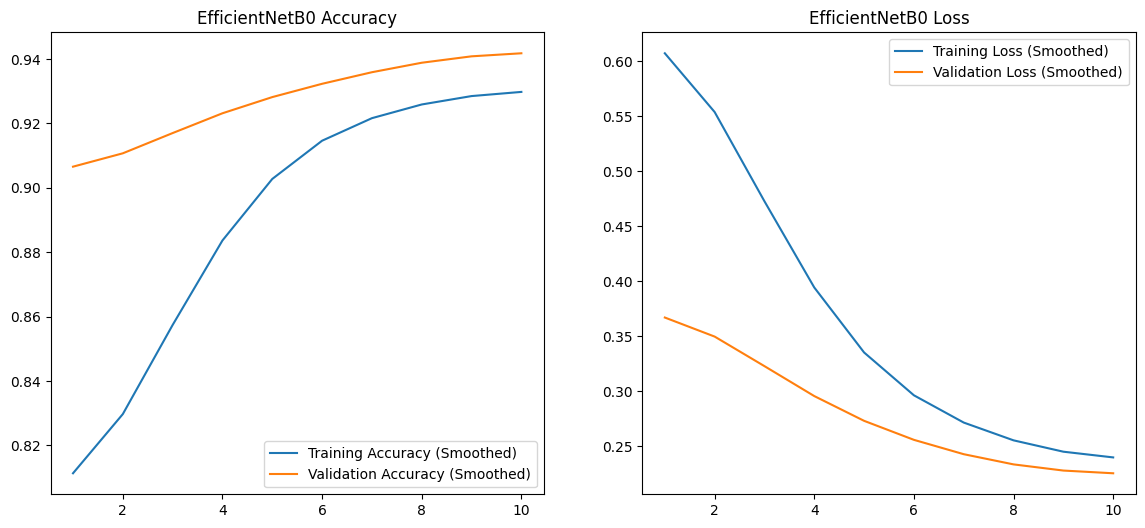

181/181 [==============================] - 158s 865ms/step

EfficientNetB0 Performance Metrics:
Accuracy: 0.95
Precision: 0.95
Recall: 0.95
AUC: 1.00
Test Time: 158.67 seconds
CPU Usage: 0.00%
Memory Usage: 216.61 MB


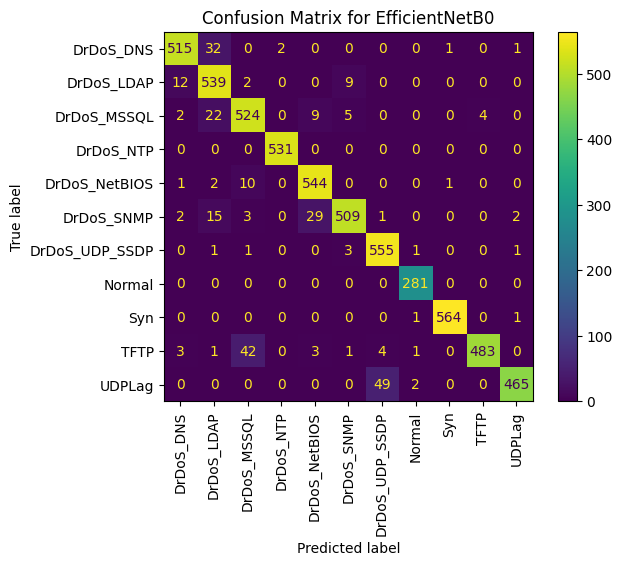

In [15]:
def measure_performance(model, test, title):
    process = psutil.Process()  # Get current process for resource usage
    start_time = time.time()  # Start time
    
    predictions = model.predict(test)  # Make predictions
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test.labels
    true_classes_one_hot = tf.keras.utils.to_categorical(true_classes, num_classes=len(test.class_indices))
    
    end_time = time.time()  # End time
    elapsed_time = end_time - start_time  # Compute elapsed time

    # Calculate CPU and Memory Usage
    cpu_percent = process.cpu_percent(interval=None)
    memory_info = process.memory_info()
    memory_usage_mb = memory_info.rss / (1024 ** 2)  # Convert to MB

    # Calculate Metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    auc = roc_auc_score(true_classes_one_hot, predictions, multi_class='ovr')

    # Print Metrics
    print(f"\n{title} Performance Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"AUC: {auc:.2f}")
    print(f"Test Time: {elapsed_time:.2f} seconds")
    print(f"CPU Usage: {cpu_percent:.2f}%")
    print(f"Memory Usage: {memory_usage_mb:.2f} MB")

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test.class_indices.keys())
    disp.plot(cmap="viridis", xticks_rotation='vertical')
    plt.title(f"Confusion Matrix for {title}")
    plt.show()
    # Main Script for EfficientNetB0 Experiment
DDoS_dir = r'C:\Users\amerl\Desktop'  # Adjust path as needed
dataset_dir = "blended"  # Dataset directory

# Train EfficientNetB0 Model
efficientnet_model, efficientnet_history, test_gen = build_and_train_efficientnet(
    efficientnet_preprocess_input, dataset_dir, DDoS_dir, (224, 224, 3),
    EfficientNetB0(include_top=False, input_shape=(224, 224, 3)),
    n_classes=11,
    augment_data=True,
    epochs=10
)

# Plot Accuracy and Loss
plot_accuracy_loss(efficientnet_history, "EfficientNetB0")

# Measure Performance
measure_performance(efficientnet_model, test_gen, "EfficientNetB0")


# EfficientNetB0 model measuring the performance with the CPU usage 

Found 14105 images belonging to 11 classes.
Found 3521 images belonging to 11 classes.
Found 6129 images belonging to 11 classes.
Epoch 1/10
441/441 [==============================] - 486s 1s/step - loss: 0.7567 - accuracy: 0.7649 - val_loss: 0.3472 - val_accuracy: 0.9071 - lr: 0.0010
Epoch 2/10
441/441 [==============================] - 474s 1s/step - loss: 0.3843 - accuracy: 0.8922 - val_loss: 0.2608 - val_accuracy: 0.9355 - lr: 0.0010
Epoch 3/10
441/441 [==============================] - 482s 1s/step - loss: 0.3211 - accuracy: 0.9116 - val_loss: 0.2580 - val_accuracy: 0.9372 - lr: 0.0010
Epoch 4/10
441/441 [==============================] - 468s 1s/step - loss: 0.2896 - accuracy: 0.9189 - val_loss: 0.2164 - val_accuracy: 0.9401 - lr: 0.0010
Epoch 5/10
441/441 [==============================] - 461s 1s/step - loss: 0.2586 - accuracy: 0.9272 - val_loss: 0.1970 - val_accuracy: 0.9494 - lr: 0.0010
Epoch 6/10
441/441 [==============================] - 462s 1s/step - loss: 0.2430 - accura

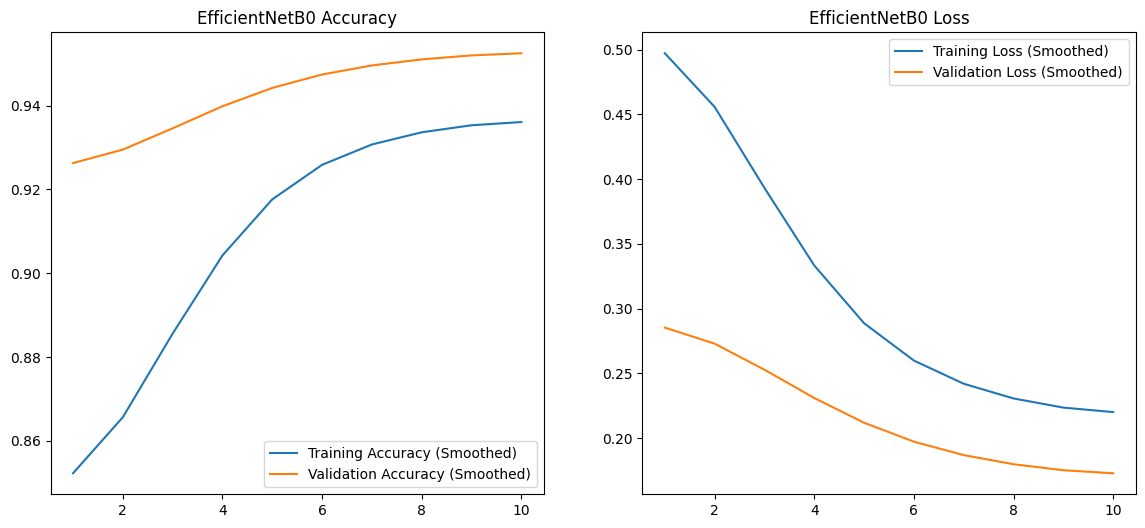

192/192 [==============================] - 163s 841ms/step

EfficientNetB0 Performance Metrics:
Accuracy: 0.96
Precision: 0.96
Recall: 0.96
AUC: 1.00
Testing Time: 163.12s
Average CPU Usage During Testing: 55.65%


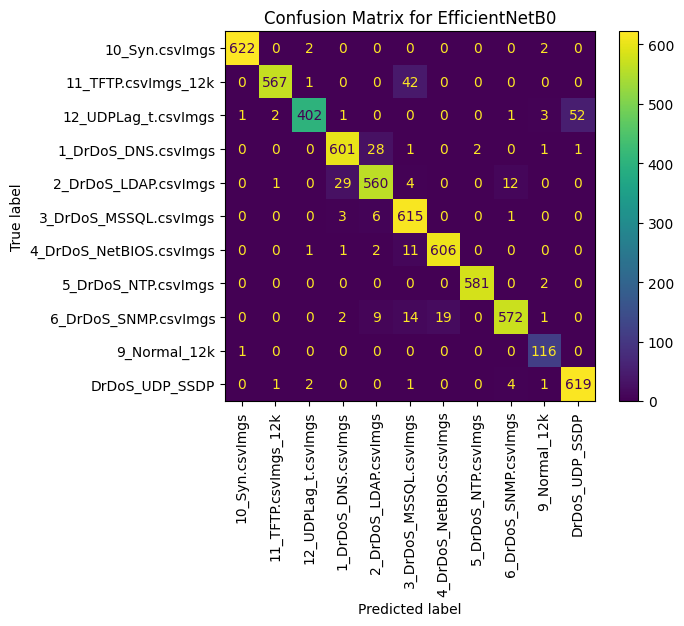

In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time
from scipy.ndimage import gaussian_filter1d
import psutil

# Helper Function to Build and Train the Model
def build_and_train_efficientnet(preprocess_fx, dataset_dir, output_dir, input_shape, base_model, n_classes, augment_data=True, epochs=10):
    # Data Augmentation
    if augment_data:
        data_gen = ImageDataGenerator(
            preprocessing_function=preprocess_fx,
            validation_split=0.2,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True
        )
    else:
        data_gen = ImageDataGenerator(
            preprocessing_function=preprocess_fx,
            validation_split=0.2
        )
    
    # Data Generators
    train_gen = data_gen.flow_from_directory(
        os.path.join(dataset_dir, "train"),
        target_size=input_shape[:2],
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )
    val_gen = data_gen.flow_from_directory(
        os.path.join(dataset_dir, "train"),
        target_size=input_shape[:2],
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )
    test_gen = data_gen.flow_from_directory(
        os.path.join(dataset_dir, "test"),
        target_size=input_shape[:2],
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    # Build the Model
    base_model.trainable = False  # Freeze the base model
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Add Dropout for Regularization
    outputs = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    # Compile the Model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

    # Measure CPU Utilization and Training Time
    process = psutil.Process()
    cpu_usage_training_start = process.cpu_percent(interval=None)
    start_time = time.time()

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr]
    )

    cpu_usage_training_end = process.cpu_percent(interval=None)
    end_time = time.time()

    avg_cpu_training = (cpu_usage_training_start + cpu_usage_training_end) / 2
    print(f"Training Time: {end_time - start_time:.2f}s")
    print(f"Average CPU Usage During Training: {avg_cpu_training:.2f}%")

    return model, history, test_gen

# Plot Accuracy and Loss
def plot_accuracy_loss(history, title):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, gaussian_filter1d(train_acc, sigma=2), label='Training Accuracy (Smoothed)')
    plt.plot(epochs, gaussian_filter1d(val_acc, sigma=2), label='Validation Accuracy (Smoothed)')
    plt.title(f'{title} Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, gaussian_filter1d(train_loss, sigma=2), label='Training Loss (Smoothed)')
    plt.plot(epochs, gaussian_filter1d(val_loss, sigma=2), label='Validation Loss (Smoothed)')
    plt.title(f'{title} Loss')
    plt.legend()

    plt.show()

# Performance Measurement with Metrics
def measure_performance(model, test, title):
    process = psutil.Process()
    cpu_usage_testing_start = process.cpu_percent(interval=None)
    start_time = time.time()

    predictions = model.predict(test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test.labels
    true_classes_one_hot = tf.keras.utils.to_categorical(true_classes, num_classes=len(test.class_indices))

    end_time = time.time()
    cpu_usage_testing_end = process.cpu_percent(interval=None)

    avg_cpu_testing = (cpu_usage_testing_start + cpu_usage_testing_end) / 2
    testing_time = end_time - start_time

    # Calculate Metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    auc = roc_auc_score(true_classes_one_hot, predictions, multi_class='ovr')

    # Print Metrics
    print(f"\n{title} Performance Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"AUC: {auc:.2f}")
    print(f"Testing Time: {testing_time:.2f}s")
    print(f"Average CPU Usage During Testing: {avg_cpu_testing:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test.class_indices.keys())
    disp.plot(cmap="viridis", xticks_rotation='vertical')
    plt.title(f"Confusion Matrix for {title}")
    plt.show()

# Main Script for EfficientNetB0 Experiment
DDoS_dir = r'C:\Users\amerl\Desktop'  # Adjust path as needed
dataset_dir = "blended"  # Dataset directory

# Train EfficientNetB0 Model
efficientnet_model, efficientnet_history, test_gen = build_and_train_efficientnet(
    efficientnet_preprocess_input, dataset_dir, DDoS_dir, (224, 224, 3),
    EfficientNetB0(include_top=False, input_shape=(224, 224, 3)),
    n_classes=11,
    augment_data=True,
    epochs=10
)

# Plot Accuracy and Loss
plot_accuracy_loss(efficientnet_history, "EfficientNetB0")

# Measure Performance
measure_performance(efficientnet_model, test_gen, "EfficientNetB0")


# Xception Model 

Found 7942 images belonging to 11 classes.
Found 1979 images belonging to 11 classes.
Found 5792 images belonging to 11 classes.
Epoch 1/10
249/249 [==============================] - 416s 2s/step - loss: 0.7951 - accuracy: 0.7492 - val_loss: 0.4359 - val_accuracy: 0.8717 - lr: 0.0010
Epoch 2/10
249/249 [==============================] - 416s 2s/step - loss: 0.4441 - accuracy: 0.8689 - val_loss: 0.3689 - val_accuracy: 0.8909 - lr: 0.0010
Epoch 3/10
249/249 [==============================] - 413s 2s/step - loss: 0.3770 - accuracy: 0.8902 - val_loss: 0.3127 - val_accuracy: 0.9035 - lr: 0.0010
Epoch 4/10
249/249 [==============================] - 411s 2s/step - loss: 0.3377 - accuracy: 0.8996 - val_loss: 0.3252 - val_accuracy: 0.9060 - lr: 0.0010
Epoch 5/10
249/249 [==============================] - 410s 2s/step - loss: 0.3191 - accuracy: 0.9066 - val_loss: 0.2855 - val_accuracy: 0.9202 - lr: 0.0010
Epoch 6/10
249/249 [==============================] - 412s 2s/step - loss: 0.3069 - accurac

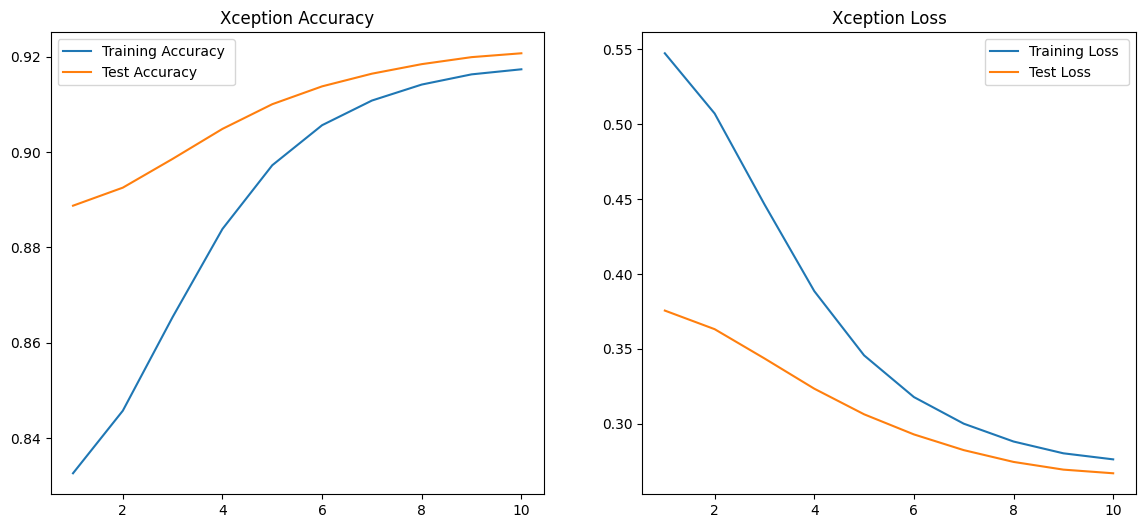

181/181 [==============================] - 256s 1s/step

Xception Performance Metrics:
Accuracy: 0.93
Precision: 0.94
Recall: 0.93
AUC: 1.00


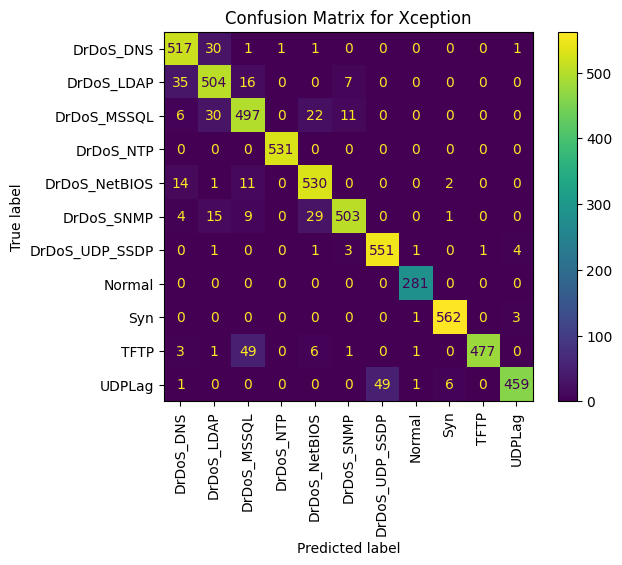

In [12]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time
from scipy.ndimage import gaussian_filter1d
import psutil

# Helper Function to Build and Train the Model
def build_and_train_xception(preprocess_fx, dataset_dir, output_dir, input_shape, base_model, n_classes, augment_data=True, epochs=10):
    # Data Augmentation
    if augment_data:
        data_gen = ImageDataGenerator(
            preprocessing_function=preprocess_fx,
            validation_split=0.2,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True
        )
    else:
        data_gen = ImageDataGenerator(
            preprocessing_function=preprocess_fx,
            validation_split=0.2
        )
    
    # Data Generators
    train_gen = data_gen.flow_from_directory(
        os.path.join(dataset_dir, "train"),
        target_size=input_shape[:2],
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )
    val_gen = data_gen.flow_from_directory(
        os.path.join(dataset_dir, "train"),
        target_size=input_shape[:2],
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )
    test_gen = data_gen.flow_from_directory(
        os.path.join(dataset_dir, "test"),
        target_size=input_shape[:2],
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    # Build the Model
    base_model.trainable = False  # Freeze the base model
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Add Dropout for Regularization
    outputs = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    # Compile the Model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

    # Train the Model
    start_time = time.time()
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr]
    )
    end_time = time.time()
    print(f"Training Time: {end_time - start_time:.2f}s")

    return model, history, test_gen

# Plot Accuracy and Loss
def plot_accuracy_loss(history, title):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, gaussian_filter1d(train_acc, sigma=2), label='Training Accuracy ')
    plt.plot(epochs, gaussian_filter1d(val_acc, sigma=2), label='Test Accuracy ')
    plt.title(f'{title} Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, gaussian_filter1d(train_loss, sigma=2), label='Training Loss ')
    plt.plot(epochs, gaussian_filter1d(val_loss, sigma=2), label='Test Loss ')
    plt.title(f'{title} Loss')
    plt.legend()

    plt.show()

# Performance Measurement with Metrics
def measure_performance(model, test, title):
    predictions = model.predict(test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test.labels
    true_classes_one_hot = tf.keras.utils.to_categorical(true_classes, num_classes=len(test.class_indices))

    # Calculate Metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    auc = roc_auc_score(true_classes_one_hot, predictions, multi_class='ovr')

    # Print Metrics
    print(f"\n{title} Performance Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"AUC: {auc:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test.class_indices.keys())
    disp.plot(cmap="viridis", xticks_rotation='vertical')
    plt.title(f"Confusion Matrix for {title}")
    plt.show()

# Main Script for Xception Experiment
DDoS_dir = r'C:\Users\amerl\Desktop'  # Adjust path as needed
dataset_dir = "blended"  # Dataset directory

# Train Xception Model
xception_model, xception_history, test_gen = build_and_train_xception(
    xception_preprocess_input, dataset_dir, DDoS_dir, (224, 224, 3),
    Xception(include_top=False, input_shape=(224, 224, 3)),
    n_classes=11,
    augment_data=True,
    epochs=10
)

# Plot Accuracy and Loss
plot_accuracy_loss(xception_history, "Xception")

# Measure Performance
measure_performance(xception_model, test_gen, "Xception")


# Xception Model measuring the performance with the Memory usage 

Found 7942 images belonging to 11 classes.
Found 1979 images belonging to 11 classes.
Found 5792 images belonging to 11 classes.
Epoch 1/10
249/249 [==============================] - 393s 2s/step - loss: 0.8035 - accuracy: 0.7449 - val_loss: 0.4550 - val_accuracy: 0.8757 - lr: 0.0010
Epoch 2/10
249/249 [==============================] - 377s 2s/step - loss: 0.4681 - accuracy: 0.8621 - val_loss: 0.3725 - val_accuracy: 0.8994 - lr: 0.0010
Epoch 3/10
249/249 [==============================] - 368s 1s/step - loss: 0.4120 - accuracy: 0.8762 - val_loss: 0.3327 - val_accuracy: 0.9085 - lr: 0.0010
Epoch 4/10
249/249 [==============================] - 368s 1s/step - loss: 0.3634 - accuracy: 0.8936 - val_loss: 0.3066 - val_accuracy: 0.9161 - lr: 0.0010
Epoch 5/10
249/249 [==============================] - 370s 1s/step - loss: 0.3181 - accuracy: 0.9057 - val_loss: 0.2950 - val_accuracy: 0.9161 - lr: 0.0010
Epoch 6/10
249/249 [==============================] - 361s 1s/step - loss: 0.3079 - accurac

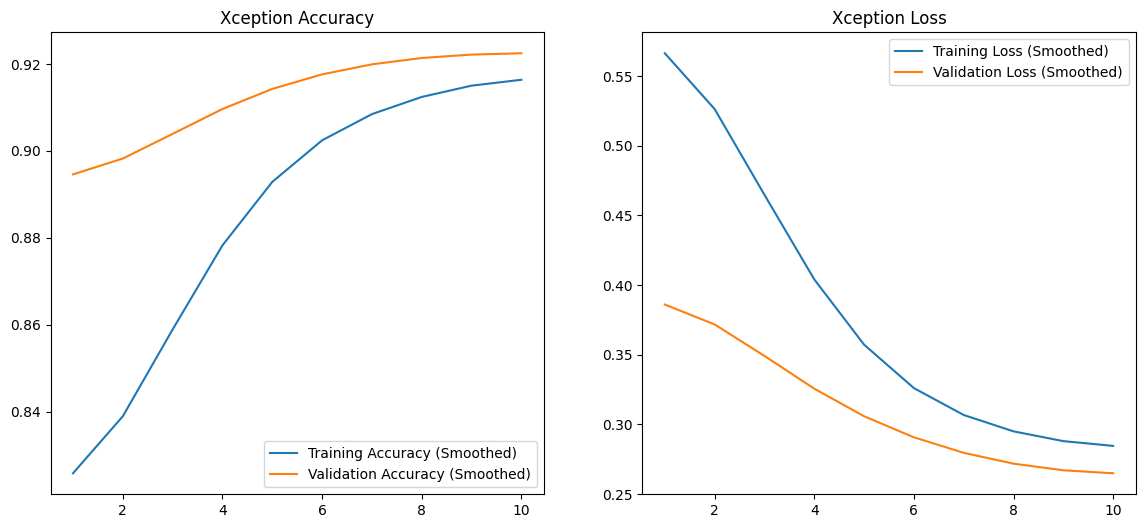

181/181 [==============================] - 214s 1s/step

Xception Performance Metrics:
Accuracy: 0.94
Precision: 0.94
Recall: 0.94
AUC: 1.00
Test Time: 214.52 seconds
CPU Usage: 0.00%
Memory Usage: 254.75 MB


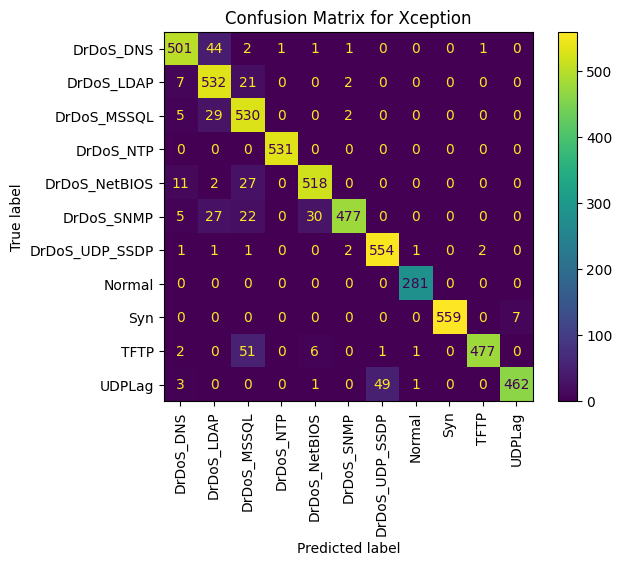

In [16]:
def measure_performance(model, test, title):
    process = psutil.Process()  # Get current process for resource usage
    start_time = time.time()  # Start time
    
    predictions = model.predict(test)  # Make predictions
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test.labels
    true_classes_one_hot = tf.keras.utils.to_categorical(true_classes, num_classes=len(test.class_indices))
    
    end_time = time.time()  # End time
    elapsed_time = end_time - start_time  # Compute elapsed time

    # Calculate CPU and Memory Usage
    cpu_percent = process.cpu_percent(interval=None)
    memory_info = process.memory_info()
    memory_usage_mb = memory_info.rss / (1024 ** 2)  # Convert to MB

    # Calculate Metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    auc = roc_auc_score(true_classes_one_hot, predictions, multi_class='ovr')

    # Print Metrics
    print(f"\n{title} Performance Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"AUC: {auc:.2f}")
    print(f"Test Time: {elapsed_time:.2f} seconds")
    print(f"CPU Usage: {cpu_percent:.2f}%")
    print(f"Memory Usage: {memory_usage_mb:.2f} MB")

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test.class_indices.keys())
    disp.plot(cmap="viridis", xticks_rotation='vertical')
    plt.title(f"Confusion Matrix for {title}")
    plt.show()
# Main Script for Xception Experiment
DDoS_dir = r'C:\Users\amerl\Desktop'  # Adjust path as needed
dataset_dir = "blended"  # Dataset directory

# Train Xception Model
xception_model, xception_history, test_gen = build_and_train_xception(
    xception_preprocess_input, dataset_dir, DDoS_dir, (224, 224, 3),
    Xception(include_top=False, input_shape=(224, 224, 3)),
    n_classes=11,
    augment_data=True,
    epochs=10
)

# Plot Accuracy and Loss
plot_accuracy_loss(xception_history, "Xception")

# Measure Performance
measure_performance(xception_model, test_gen, "Xception")

# xception model measuring the performance with the CPU usage 

Found 14105 images belonging to 11 classes.
Found 3521 images belonging to 11 classes.
Found 6129 images belonging to 11 classes.
Epoch 1/10
441/441 [==============================] - 669s 2s/step - loss: 0.6872 - accuracy: 0.7840 - val_loss: 0.3766 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 2/10
441/441 [==============================] - 639s 1s/step - loss: 0.3925 - accuracy: 0.8868 - val_loss: 0.3124 - val_accuracy: 0.9103 - lr: 0.0010
Epoch 3/10
441/441 [==============================] - 641s 1s/step - loss: 0.3429 - accuracy: 0.9007 - val_loss: 0.2853 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 4/10
441/441 [==============================] - 638s 1s/step - loss: 0.3262 - accuracy: 0.9071 - val_loss: 0.2431 - val_accuracy: 0.9270 - lr: 0.0010
Epoch 5/10
441/441 [==============================] - 638s 1s/step - loss: 0.2988 - accuracy: 0.9112 - val_loss: 0.2490 - val_accuracy: 0.9242 - lr: 0.0010
Epoch 6/10
441/441 [==============================] - 638s 1s/step - loss: 0.2880 - accura

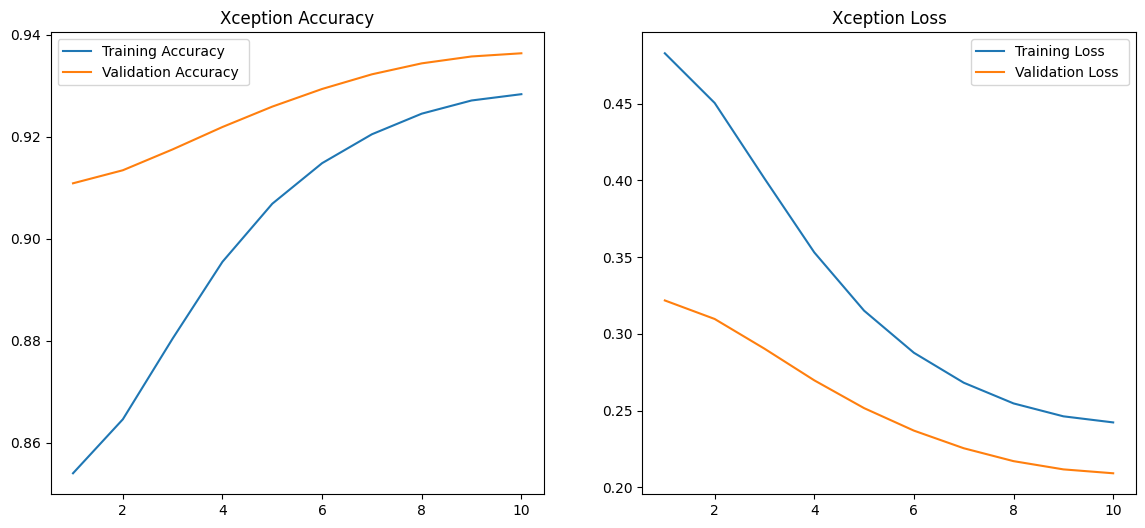

192/192 [==============================] - 235s 1s/step

Xception Performance Metrics:
Accuracy: 0.94
Precision: 0.94
Recall: 0.94
AUC: 1.00
Testing Time: 235.43s
Average CPU Usage During Testing: 118.10%


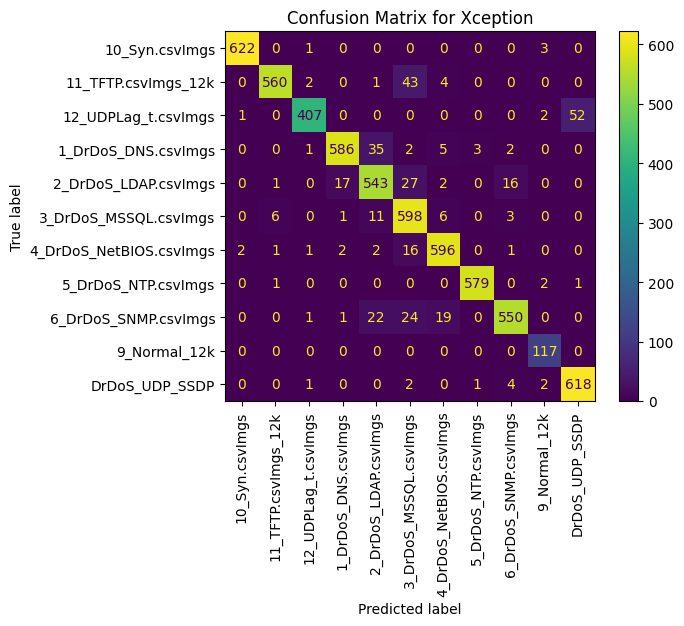

In [14]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time
from scipy.ndimage import gaussian_filter1d
import psutil

# Helper Function to Build and Train the Model
def build_and_train_xception(preprocess_fx, dataset_dir, output_dir, input_shape, base_model, n_classes, augment_data=True, epochs=10):
    # Data Augmentation
    if augment_data:
        data_gen = ImageDataGenerator(
            preprocessing_function=preprocess_fx,
            validation_split=0.2,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True
        )
    else:
        data_gen = ImageDataGenerator(
            preprocessing_function=preprocess_fx,
            validation_split=0.2
        )
    
    # Data Generators
    train_gen = data_gen.flow_from_directory(
        os.path.join(dataset_dir, "train"),
        target_size=input_shape[:2],
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )
    val_gen = data_gen.flow_from_directory(
        os.path.join(dataset_dir, "train"),
        target_size=input_shape[:2],
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )
    test_gen = data_gen.flow_from_directory(
        os.path.join(dataset_dir, "test"),
        target_size=input_shape[:2],
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    # Build the Model
    base_model.trainable = False  # Freeze the base model
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Add Dropout for Regularization
    outputs = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    # Compile the Model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

    # Measure CPU Utilization and Training Time
    process = psutil.Process()
    cpu_usage_training_start = process.cpu_percent(interval=None)
    start_time = time.time()

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr]
    )

    cpu_usage_training_end = process.cpu_percent(interval=None)
    end_time = time.time()

    avg_cpu_training = (cpu_usage_training_start + cpu_usage_training_end) / 2
    print(f"Training Time: {end_time - start_time:.2f}s")
    print(f"Average CPU Usage During Training: {avg_cpu_training:.2f}%")

    return model, history, test_gen

# Plot Accuracy and Loss
def plot_accuracy_loss(history, title):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, gaussian_filter1d(train_acc, sigma=2), label='Training Accuracy ')
    plt.plot(epochs, gaussian_filter1d(val_acc, sigma=2), label='Validation Accuracy ')
    plt.title(f'{title} Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, gaussian_filter1d(train_loss, sigma=2), label='Training Loss ')
    plt.plot(epochs, gaussian_filter1d(val_loss, sigma=2), label='Validation Loss ')
    plt.title(f'{title} Loss')
    plt.legend()

    plt.show()

# Performance Measurement with Metrics
def measure_performance(model, test, title):
    process = psutil.Process()
    cpu_usage_testing_start = process.cpu_percent(interval=None)
    start_time = time.time()

    predictions = model.predict(test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test.labels
    true_classes_one_hot = tf.keras.utils.to_categorical(true_classes, num_classes=len(test.class_indices))

    end_time = time.time()
    cpu_usage_testing_end = process.cpu_percent(interval=None)

    avg_cpu_testing = (cpu_usage_testing_start + cpu_usage_testing_end) / 2
    testing_time = end_time - start_time

    # Calculate Metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    auc = roc_auc_score(true_classes_one_hot, predictions, multi_class='ovr')

    # Print Metrics
    print(f"\n{title} Performance Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"AUC: {auc:.2f}")
    print(f"Testing Time: {testing_time:.2f}s")
    print(f"Average CPU Usage During Testing: {avg_cpu_testing:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test.class_indices.keys())
    disp.plot(cmap="viridis", xticks_rotation='vertical')
    plt.title(f"Confusion Matrix for {title}")
    plt.show()

# Main Script for Xception Experiment
DDoS_dir = r'C:\Users\amerl\Desktop'  # Adjust path as needed
dataset_dir = "blended"  # Dataset directory

# Train Xception Model
xception_model, xception_history, test_gen = build_and_train_xception(
    xception_preprocess_input, dataset_dir, DDoS_dir, (224, 224, 3),
    Xception(include_top=False, input_shape=(224, 224, 3)),
    n_classes=11,
    augment_data=True,
    epochs=10
)

# Plot Accuracy and Loss
plot_accuracy_loss(xception_history, "Xception")

# Measure Performance
measure_performance(xception_model, test_gen, "Xception")


# MobilenetV3 Model 

Found 7942 images belonging to 11 classes.
Found 1979 images belonging to 11 classes.
Found 5792 images belonging to 11 classes.
Epoch 1/10
249/249 [==============================] - 194s 739ms/step - loss: 1.2553 - accuracy: 0.5807 - val_loss: 2.1403 - val_accuracy: 0.3194 - lr: 1.0000e-04
Epoch 2/10
249/249 [==============================] - 178s 716ms/step - loss: 0.3531 - accuracy: 0.8999 - val_loss: 1.6524 - val_accuracy: 0.4310 - lr: 1.0000e-04
Epoch 3/10
249/249 [==============================] - 176s 705ms/step - loss: 0.2288 - accuracy: 0.9334 - val_loss: 1.0121 - val_accuracy: 0.6539 - lr: 1.0000e-04
Epoch 4/10
249/249 [==============================] - 175s 703ms/step - loss: 0.1922 - accuracy: 0.9435 - val_loss: 0.5646 - val_accuracy: 0.8135 - lr: 1.0000e-04
Epoch 5/10
249/249 [==============================] - 176s 706ms/step - loss: 0.1631 - accuracy: 0.9534 - val_loss: 0.4366 - val_accuracy: 0.8540 - lr: 1.0000e-04
Epoch 6/10
249/249 [==============================] - 17

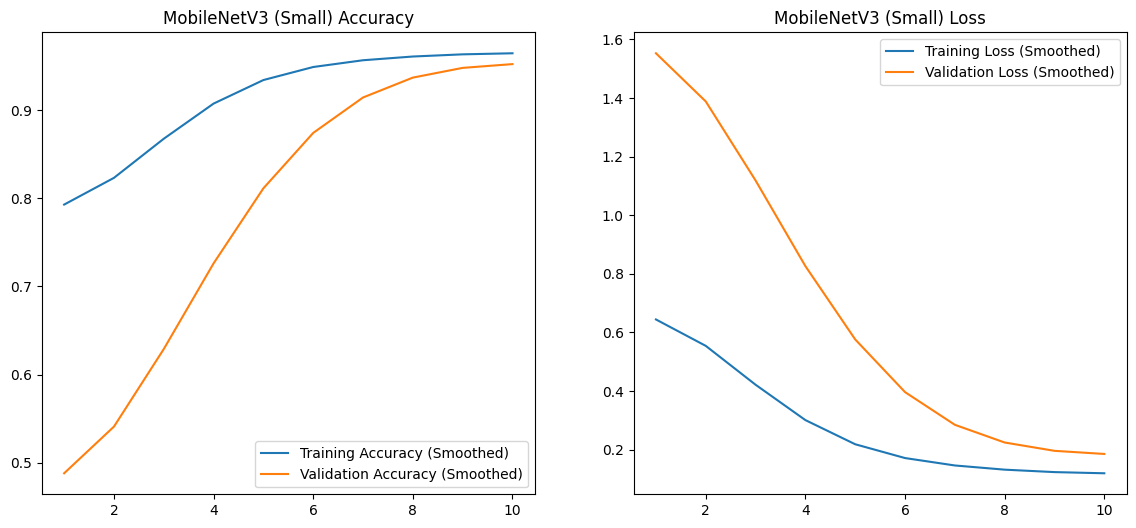

181/181 [==============================] - 31s 167ms/step

MobileNetV3 (Small) Performance Metrics:
Accuracy: 0.97
Precision: 0.97
Recall: 0.97
AUC: 1.00


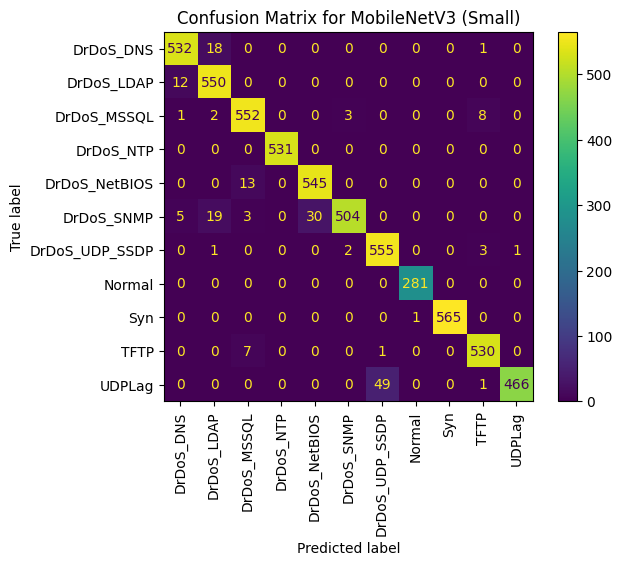

In [13]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenetv3_preprocess_input
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy.ndimage import gaussian_filter1d
import time

# Helper Function to Train MobileNetV3 Small
def train_mobilenetv3_small(preprocess_fn, train_dir, test_dir, input_shape, n_classes, frozen=False, epochs=10):
    # Initialize the MobileNetV3 Small model
    base_model = MobileNetV3Small(include_top=False, input_shape=input_shape, weights='imagenet')

    # Freeze the base model if specified
    if frozen:
        base_model.trainable = False

    # Add classification layers
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(n_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Data Augmentation and Generators
    train_gen = ImageDataGenerator(
        preprocessing_function=preprocess_fn,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        validation_split=0.2
    )
    train_data = train_gen.flow_from_directory(
        directory=train_dir,
        target_size=(input_shape[0], input_shape[1]),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )
    val_data = train_gen.flow_from_directory(
        directory=train_dir,
        target_size=(input_shape[0], input_shape[1]),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )
    test_data = ImageDataGenerator(preprocessing_function=preprocess_fn).flow_from_directory(
        directory=test_dir,
        target_size=(input_shape[0], input_shape[1]),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

    # Train the Model
    start_time = time.time()
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr]
    )
    end_time = time.time()
    print(f"Training Time: {end_time - start_time:.2f}s")

    return model, history, test_data

# Plot Accuracy and Loss
def plot_accuracy_loss(history, title):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, gaussian_filter1d(train_acc, sigma=2), label='Training Accuracy (Smoothed)')
    plt.plot(epochs, gaussian_filter1d(val_acc, sigma=2), label='Validation Accuracy (Smoothed)')
    plt.title(f'{title} Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, gaussian_filter1d(train_loss, sigma=2), label='Training Loss (Smoothed)')
    plt.plot(epochs, gaussian_filter1d(val_loss, sigma=2), label='Validation Loss (Smoothed)')
    plt.title(f'{title} Loss')
    plt.legend()

    plt.show()

# Performance Measurement with Metrics
def measure_performance(model, test, title):
    predictions = model.predict(test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test.labels
    true_classes_one_hot = tf.keras.utils.to_categorical(true_classes, num_classes=len(test.class_indices))

    # Calculate Metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    auc = roc_auc_score(true_classes_one_hot, predictions, multi_class='ovr')

    # Print Metrics
    print(f"\n{title} Performance Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"AUC: {auc:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test.class_indices.keys())
    disp.plot(cmap="viridis", xticks_rotation='vertical')
    plt.title(f"Confusion Matrix for {title}")
    plt.show()

# Main Script for MobileNetV3 Small
mobilenetv3_small_model, mobilenetv3_small_history, test_gen = train_mobilenetv3_small(
    preprocess_fn=mobilenetv3_preprocess_input,
    train_dir="blended/train",
    test_dir="blended/test",
    input_shape=(224, 224, 3),
    n_classes=11,
    frozen=False,  # Set to True for transfer learning
    epochs=10
)

# Plot Accuracy and Loss
plot_accuracy_loss(mobilenetv3_small_history, "MobileNetV3 (Small)")

# Measure Performance
measure_performance(mobilenetv3_small_model, test_gen, "MobileNetV3 (Small)")


# MobilenetV3 Model measuring the performance with the memory usage 

Found 7942 images belonging to 11 classes.
Found 1979 images belonging to 11 classes.
Found 5792 images belonging to 11 classes.
Epoch 1/10
249/249 [==============================] - 191s 718ms/step - loss: 1.2263 - accuracy: 0.6123 - val_loss: 2.7796 - val_accuracy: 0.2122 - lr: 1.0000e-04
Epoch 2/10
249/249 [==============================] - 175s 703ms/step - loss: 0.3282 - accuracy: 0.9049 - val_loss: 2.3132 - val_accuracy: 0.3744 - lr: 1.0000e-04
Epoch 3/10
249/249 [==============================] - 175s 703ms/step - loss: 0.2206 - accuracy: 0.9373 - val_loss: 1.7515 - val_accuracy: 0.5013 - lr: 1.0000e-04
Epoch 4/10
249/249 [==============================] - 174s 700ms/step - loss: 0.1777 - accuracy: 0.9457 - val_loss: 1.3241 - val_accuracy: 0.5584 - lr: 1.0000e-04
Epoch 5/10
249/249 [==============================] - 173s 696ms/step - loss: 0.1591 - accuracy: 0.9523 - val_loss: 0.7679 - val_accuracy: 0.7029 - lr: 1.0000e-04
Epoch 6/10
249/249 [==============================] - 17

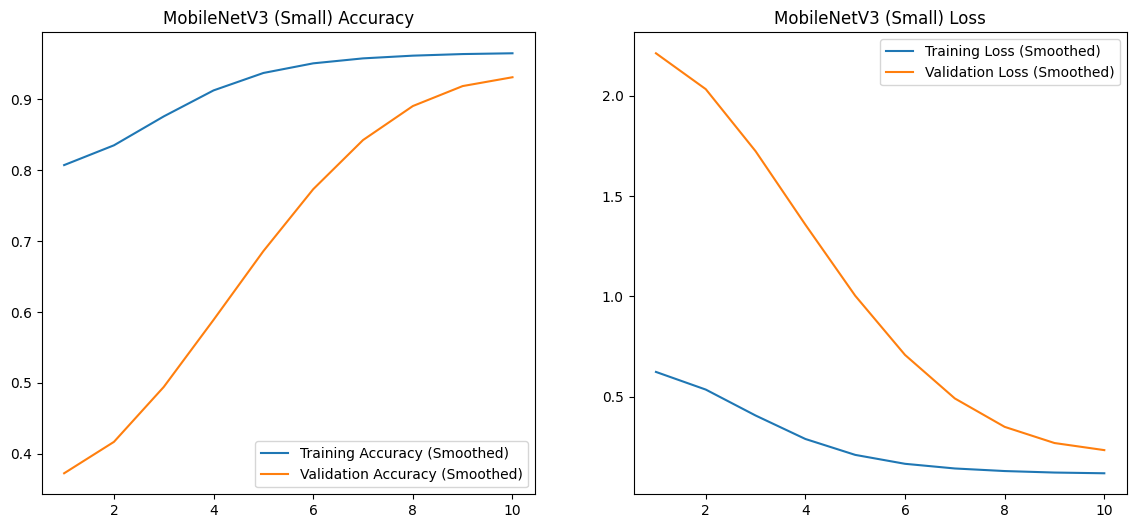

181/181 [==============================] - 32s 170ms/step

MobileNetV3 (Small) Performance Metrics:
Accuracy: 0.96
Precision: 0.96
Recall: 0.96
AUC: 1.00
Test Time: 31.83 seconds
CPU Usage: 0.00%
Memory Usage: 267.23 MB


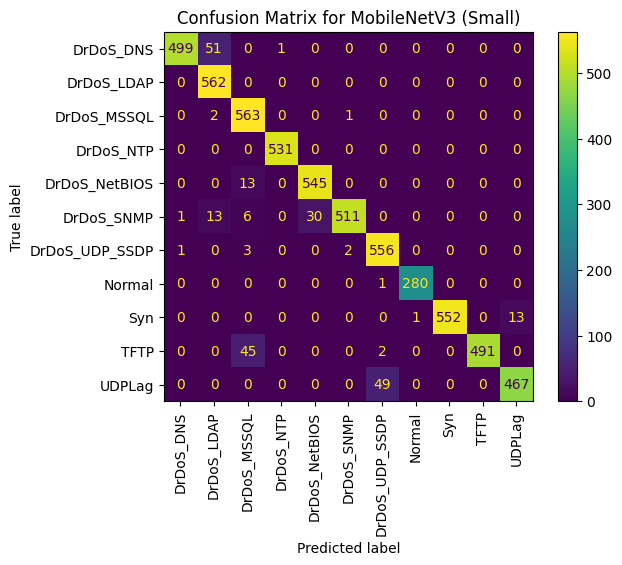

In [17]:
def measure_performance(model, test, title):
    process = psutil.Process()  # Get current process for resource usage
    start_time = time.time()  # Start time
    
    predictions = model.predict(test)  # Make predictions
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test.labels
    true_classes_one_hot = tf.keras.utils.to_categorical(true_classes, num_classes=len(test.class_indices))
    
    end_time = time.time()  # End time
    elapsed_time = end_time - start_time  # Compute elapsed time

    # Calculate CPU and Memory Usage
    cpu_percent = process.cpu_percent(interval=None)
    memory_info = process.memory_info()
    memory_usage_mb = memory_info.rss / (1024 ** 2)  # Convert to MB

    # Calculate Metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    auc = roc_auc_score(true_classes_one_hot, predictions, multi_class='ovr')

    # Print Metrics
    print(f"\n{title} Performance Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"AUC: {auc:.2f}")
    print(f"Test Time: {elapsed_time:.2f} seconds")
    print(f"CPU Usage: {cpu_percent:.2f}%")
    print(f"Memory Usage: {memory_usage_mb:.2f} MB")

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test.class_indices.keys())
    disp.plot(cmap="viridis", xticks_rotation='vertical')
    plt.title(f"Confusion Matrix for {title}")
    plt.show()
# Main Script for MobileNetV3 Small
mobilenetv3_small_model, mobilenetv3_small_history, test_gen = train_mobilenetv3_small(
    preprocess_fn=mobilenetv3_preprocess_input,
    train_dir="blended/train",
    test_dir="blended/test",
    input_shape=(224, 224, 3),
    n_classes=11,
    frozen=False,  # Set to True for transfer learning
    epochs=10
)

# Plot Accuracy and Loss
plot_accuracy_loss(mobilenetv3_small_history, "MobileNetV3 (Small)")

# Measure Performance
measure_performance(mobilenetv3_small_model, test_gen, "MobileNetV3 (Small)")

# MobilenetV3 Model measuring the performance with the CPU usage 

Found 5887 images belonging to 11 classes.
Found 1466 images belonging to 11 classes.
Found 1842 images belonging to 11 classes.
Epoch 1/10
184/184 [==============================] - 182s 939ms/step - loss: 1.4799 - accuracy: 0.5206 - val_loss: 2.2109 - val_accuracy: 0.1985 - lr: 1.0000e-04
Epoch 2/10
184/184 [==============================] - 160s 865ms/step - loss: 0.4938 - accuracy: 0.8507 - val_loss: 1.7641 - val_accuracy: 0.2920 - lr: 1.0000e-04
Epoch 3/10
184/184 [==============================] - 158s 860ms/step - loss: 0.3056 - accuracy: 0.9115 - val_loss: 1.3945 - val_accuracy: 0.4284 - lr: 1.0000e-04
Epoch 4/10
184/184 [==============================] - 156s 850ms/step - loss: 0.2348 - accuracy: 0.9317 - val_loss: 0.9851 - val_accuracy: 0.6364 - lr: 1.0000e-04
Epoch 5/10
184/184 [==============================] - 156s 845ms/step - loss: 0.2005 - accuracy: 0.9387 - val_loss: 0.5811 - val_accuracy: 0.8315 - lr: 1.0000e-04
Epoch 6/10
184/184 [==============================] - 15

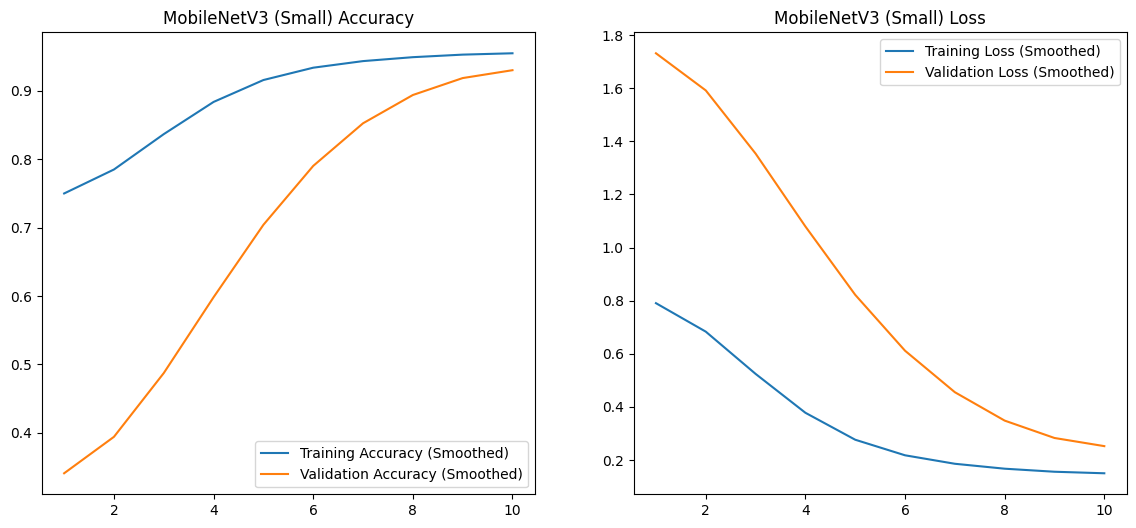

58/58 [==============================] - 13s 212ms/step

MobileNetV3 (Small) Performance Metrics:
Accuracy: 0.94
Precision: 0.95
Recall: 0.94
AUC: 1.00
Testing Time: 13.18s
Average CPU Usage During Testing: 46.40%


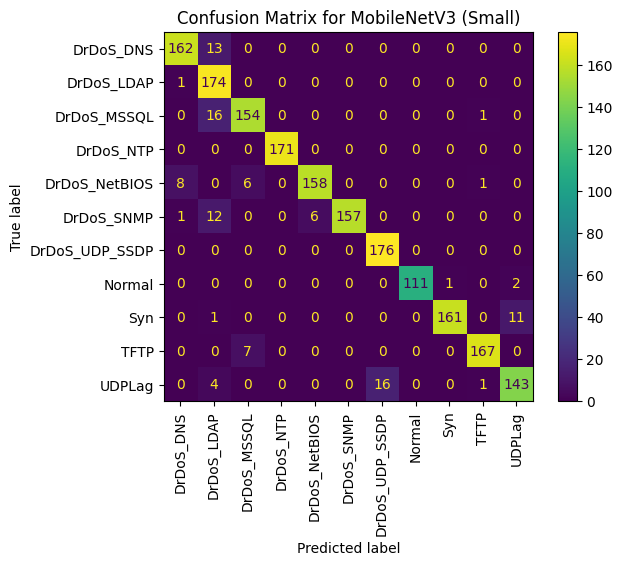

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenetv3_preprocess_input
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy.ndimage import gaussian_filter1d
import time
import psutil

# Helper Function to Train MobileNetV3 Small
def train_mobilenetv3_small(preprocess_fn, train_dir, test_dir, input_shape, n_classes, frozen=False, epochs=10):
    # Initialize the MobileNetV3 Small model
    base_model = MobileNetV3Small(include_top=False, input_shape=input_shape, weights='imagenet')

    # Freeze the base model if specified
    if frozen:
        base_model.trainable = False

    # Add classification layers
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(n_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Data Augmentation and Generators
    train_gen = ImageDataGenerator(
        preprocessing_function=preprocess_fn,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        validation_split=0.2
    )
    train_data = train_gen.flow_from_directory(
        directory=train_dir,
        target_size=(input_shape[0], input_shape[1]),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )
    val_data = train_gen.flow_from_directory(
        directory=train_dir,
        target_size=(input_shape[0], input_shape[1]),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )
    test_data = ImageDataGenerator(preprocessing_function=preprocess_fn).flow_from_directory(
        directory=test_dir,
        target_size=(input_shape[0], input_shape[1]),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

    # Measure CPU Utilization and Training Time
    process = psutil.Process()
    cpu_usage_training_start = process.cpu_percent(interval=None)
    start_time = time.time()

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr]
    )

    cpu_usage_training_end = process.cpu_percent(interval=None)
    end_time = time.time()

    avg_cpu_training = (cpu_usage_training_start + cpu_usage_training_end) / 2
    print(f"Training Time: {end_time - start_time:.2f}s")
    print(f"Average CPU Usage During Training: {avg_cpu_training:.2f}%")

    return model, history, test_data

# Plot Accuracy and Loss
def plot_accuracy_loss(history, title):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, gaussian_filter1d(train_acc, sigma=2), label='Training Accuracy (Smoothed)')
    plt.plot(epochs, gaussian_filter1d(val_acc, sigma=2), label='Validation Accuracy (Smoothed)')
    plt.title(f'{title} Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, gaussian_filter1d(train_loss, sigma=2), label='Training Loss (Smoothed)')
    plt.plot(epochs, gaussian_filter1d(val_loss, sigma=2), label='Validation Loss (Smoothed)')
    plt.title(f'{title} Loss')
    plt.legend()

    plt.show()

# Performance Measurement with Metrics
def measure_performance(model, test, title):
    process = psutil.Process()
    cpu_usage_testing_start = process.cpu_percent(interval=None)
    start_time = time.time()

    predictions = model.predict(test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test.labels
    true_classes_one_hot = tf.keras.utils.to_categorical(true_classes, num_classes=len(test.class_indices))

    end_time = time.time()
    cpu_usage_testing_end = process.cpu_percent(interval=None)

    avg_cpu_testing = (cpu_usage_testing_start + cpu_usage_testing_end) / 2
    testing_time = end_time - start_time

    # Calculate Metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    auc = roc_auc_score(true_classes_one_hot, predictions, multi_class='ovr')

    # Print Metrics
    print(f"\n{title} Performance Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"AUC: {auc:.2f}")
    print(f"Testing Time: {testing_time:.2f}s")
    print(f"Average CPU Usage During Testing: {avg_cpu_testing:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test.class_indices.keys())
    disp.plot(cmap="viridis", xticks_rotation='vertical')
    plt.title(f"Confusion Matrix for {title}")
    plt.show()

# Main Script for MobileNetV3 Small
mobilenetv3_small_model, mobilenetv3_small_history, test_gen = train_mobilenetv3_small(
    preprocess_fn=mobilenetv3_preprocess_input,
    train_dir="blended/train",
    test_dir="blended/test",
    input_shape=(224, 224, 3),
    n_classes=11,
    frozen=False,  # Set to True for transfer learning
    epochs=10
)

# Plot Accuracy and Loss
plot_accuracy_loss(mobilenetv3_small_history, "MobileNetV3 (Small)")

# Measure Performance
measure_performance(mobilenetv3_small_model, test_gen, "MobileNetV3 (Small)")


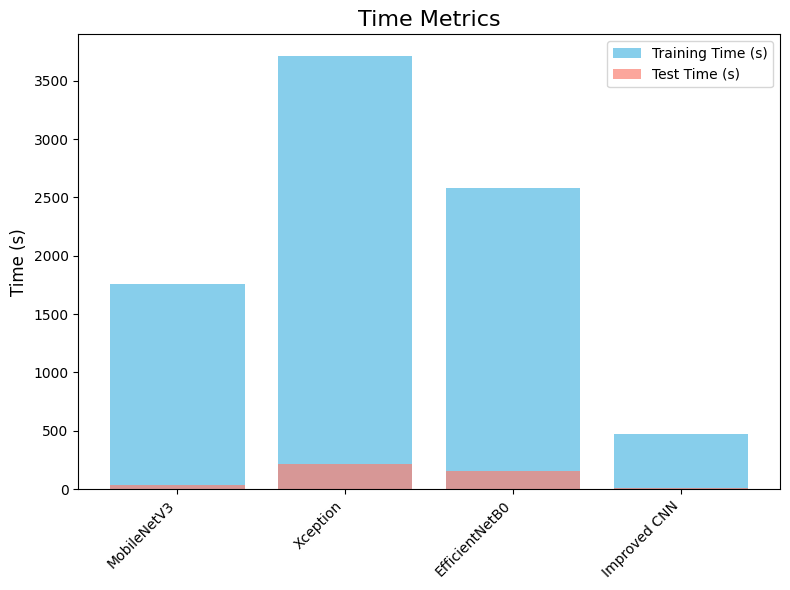

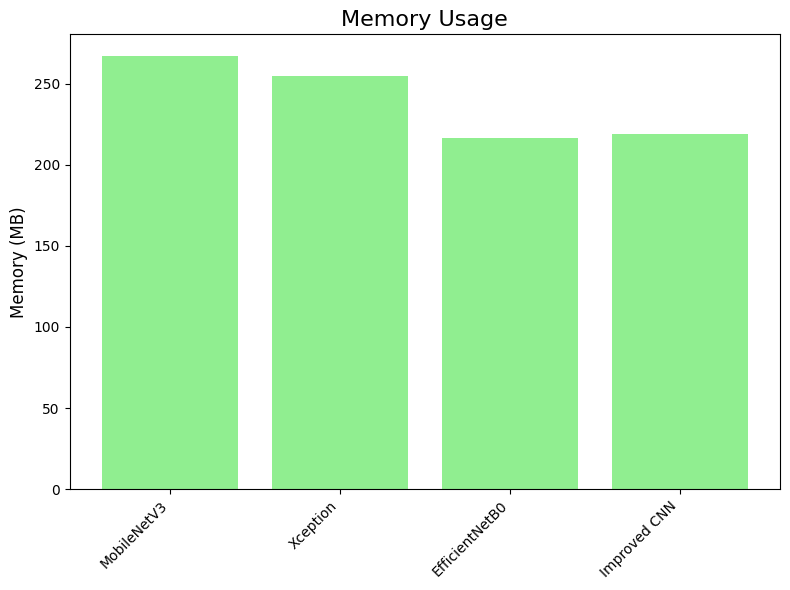

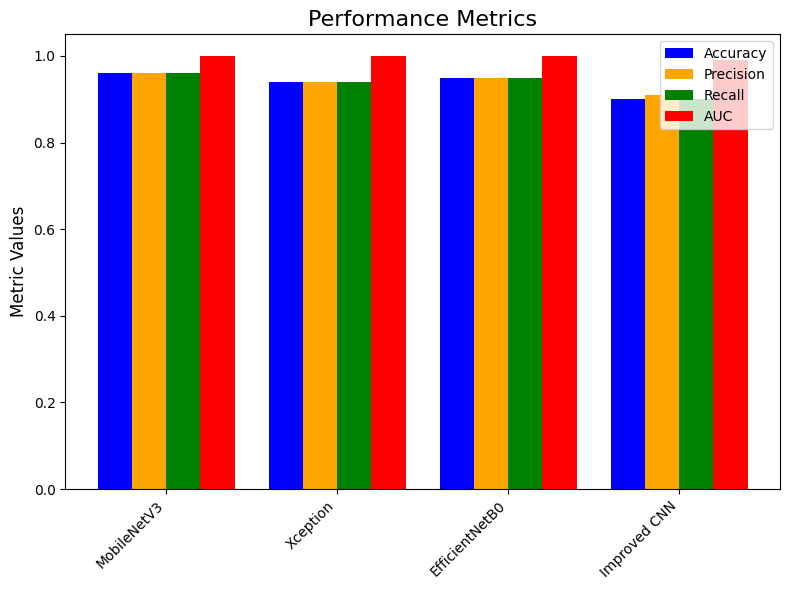

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Data for comparison
models = ['MobileNetV3', 'Xception', 'EfficientNetB0', 'Improved CNN']

# Metrics
training_time = [1760.22, 3711.79, 2578.41, 476.08]  # in seconds
test_time = [31.83, 214.52, 158.67, 8.32]  # in seconds
memory_usage = [267.23, 254.75, 216.61, 219.27]  # in MB
accuracy = [0.96, 0.94, 0.95, 0.90]
precision = [0.96, 0.94, 0.95, 0.91]
recall = [0.96, 0.94, 0.95, 0.90]
auc = [1.00, 1.00, 1.00, 0.99]

# Plot 1: Training and Test Time
plt.figure(figsize=(8, 6))
plt.bar(models, training_time, color='skyblue', label='Training Time (s)')
plt.bar(models, test_time, color='salmon', label='Test Time (s)', alpha=0.7)
plt.title('Time Metrics', fontsize=16)
plt.ylabel('Time (s)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Memory Usage
plt.figure(figsize=(8, 6))
plt.bar(models, memory_usage, color='lightgreen')
plt.title('Memory Usage', fontsize=16)
plt.ylabel('Memory (MB)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

# Plot 3: Accuracy, Precision, Recall, and AUC
x = np.arange(len(models))
width = 0.2  # Bar width

plt.figure(figsize=(8, 6))
plt.bar(x - width * 1.5, accuracy, width, label='Accuracy', color='blue')
plt.bar(x - width / 2, precision, width, label='Precision', color='orange')
plt.bar(x + width / 2, recall, width, label='Recall', color='green')
plt.bar(x + width * 1.5, auc, width, label='AUC', color='red')
plt.title('Performance Metrics', fontsize=16)
plt.ylabel('Metric Values', fontsize=12)
plt.xticks(x, models, rotation=45, ha='right', fontsize=10)
plt.legend()
plt.tight_layout()
plt.show()


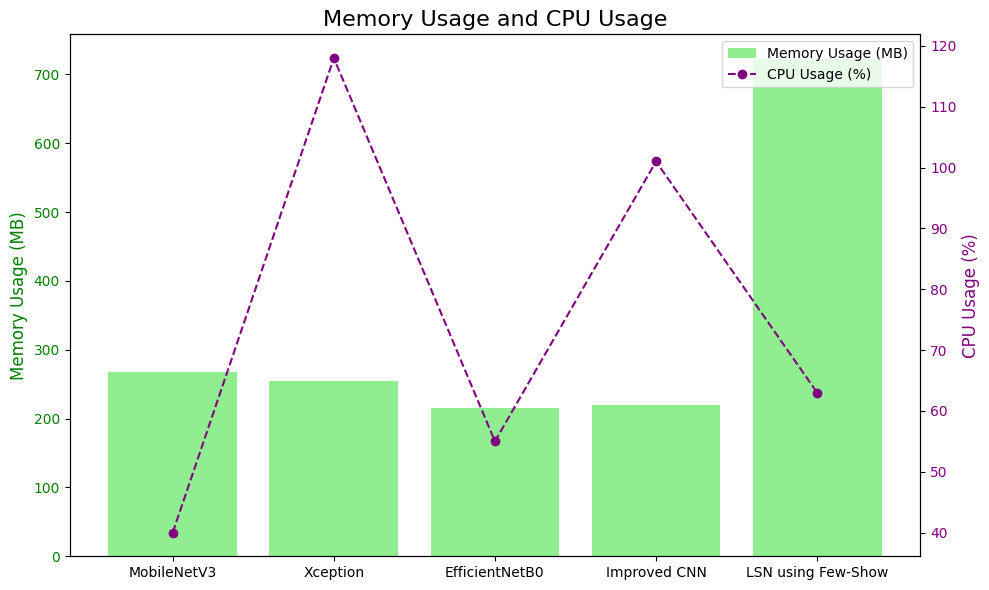

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['MobileNetV3', 'Xception', 'EfficientNetB0', 'Improved CNN', 'LSN using Few-Show']
memory_usage = [267, 254, 216, 219, 722]  # Memory Usage in MB
cpu_usage = [40, 118, 55, 101, 63]  # CPU Usage in %

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for Memory Usage
ax1.bar(models, memory_usage, color='lightgreen', label='Memory Usage (MB)')
ax1.set_ylabel('Memory Usage (MB)', color='green', fontsize=12)
ax1.tick_params(axis='y', labelcolor='green')

# Line plot for CPU Usage (secondary y-axis)
ax2 = ax1.twinx()
ax2.plot(models, cpu_usage, color='purple', linestyle='--', marker='o', label='CPU Usage (%)')
ax2.set_ylabel('CPU Usage (%)', color='purple', fontsize=12)
ax2.tick_params(axis='y', labelcolor='purple')

# Title and layout
plt.title('Memory Usage and CPU Usage', fontsize=16)
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

# Show plot
plt.show()


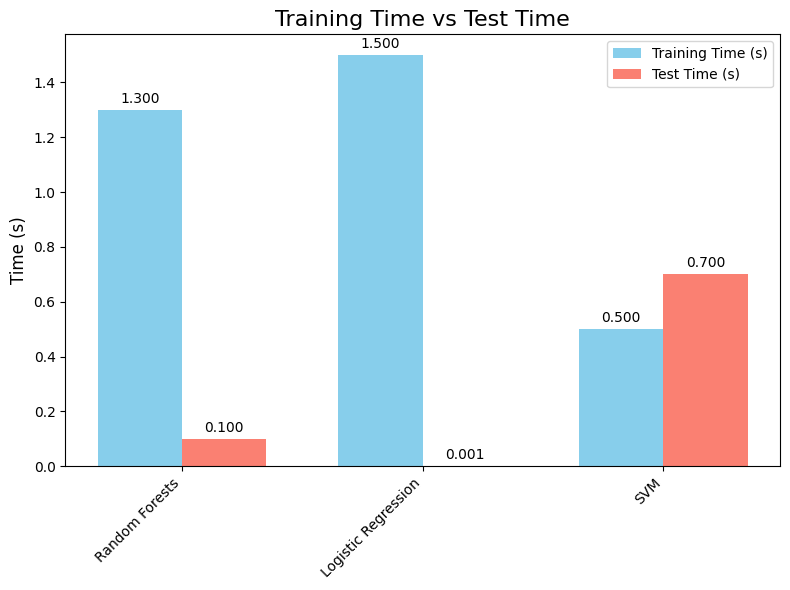

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Random Forests', 'Logistic Regression', 'SVM']
training_time = [1.30, 1.50, 0.50]  # Training Time (s)
test_time = [0.10, 0.001, 0.70]     # Test Time (s)

# Plot the Training and Test Time
x = np.arange(len(models))  # The label locations
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(8, 6))

# Bar plots
bars1 = ax.bar(x - width/2, training_time, width, label='Training Time (s)', color='skyblue')
bars2 = ax.bar(x + width/2, test_time, width, label='Test Time (s)', color='salmon')

# Add labels and title
ax.set_ylabel('Time (s)', fontsize=12)
ax.set_title('Training Time vs Test Time', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

# Add values on top of bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset above bar
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


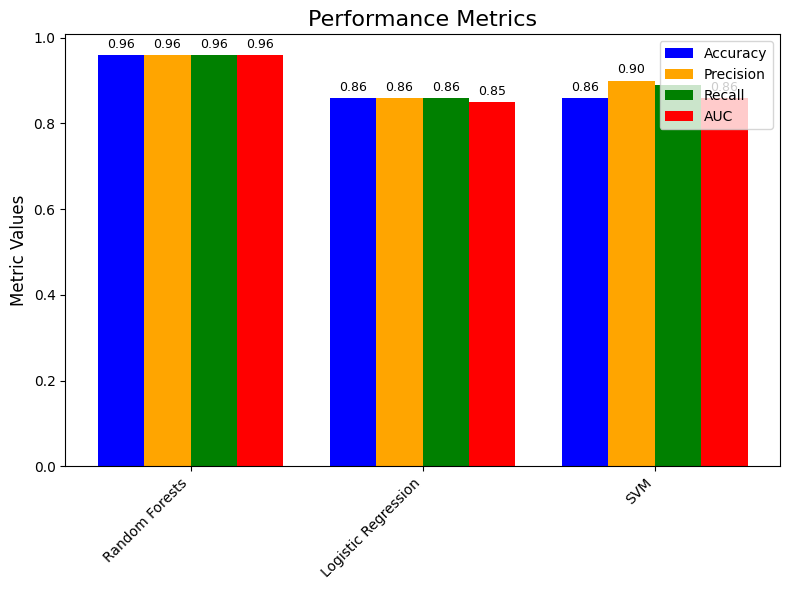

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Random Forests', 'Logistic Regression', 'SVM']
accuracy = [0.96, 0.86, 0.86]
precision = [0.96, 0.86, 0.90]
recall = [0.96, 0.86, 0.89]
auc = [0.96, 0.85, 0.86]

# Plotting grouped bar chart
x = np.arange(len(models))  # Label locations
width = 0.2  # Width of bars

fig, ax = plt.subplots(figsize=(8, 6))

# Bars for each metric
bars1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy', color='blue')
bars2 = ax.bar(x - 0.5*width, precision, width, label='Precision', color='orange')
bars3 = ax.bar(x + 0.5*width, recall, width, label='Recall', color='green')
bars4 = ax.bar(x + 1.5*width, auc, width, label='AUC', color='red')

# Labels and title
ax.set_ylabel('Metric Values', fontsize=12)
ax.set_title('Performance Metrics', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

# Adding values on top of bars
def add_values(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

add_values(bars1)
add_values(bars2)
add_values(bars3)
add_values(bars4)

plt.tight_layout()
plt.show()
